In [1]:
import phizz
import pandas as pd

In [2]:
spg_genotypes = pd.read_csv('hpo_term_analysis/omim_codes.csv')
omim_codes = spg_genotypes.OMIM

In [3]:
hpo_terms = {
    'hpo_term': [],
    'description': []
}

for omim in omim_codes:
    prepend = 'OMIM:'
    omim = str(omim).strip('.0')
    omim = prepend + omim
    if not omim == 'OMIM:nan':
        query_dict =  phizz.query_disease([omim])
    else:
        continue
    for result in query_dict:
        hpo_terms['hpo_term'].append(result['hpo_term'])
        hpo_terms['description'].append(result['description'])
        
hpo_terms_df = pd.DataFrame(data=hpo_terms).drop_duplicates('hpo_term')
hpo_terms_df.head(10)

,hpo_term,description
0,HP:0003487,Babinski sign
1,HP:0003743,Genetic anticipation
2,HP:0001347,Hyperreflexia
3,HP:0003419,Low back pain
4,HP:0002166,Impaired vibration sensation in the lower limbs
5,HP:0000639,Nystagmus
6,HP:0003587,Insidious onset
7,HP:0010550,Paraplegia
8,HP:0000726,Dementia
9,HP:0003676,Progressive


In [4]:
with open('gene_lists/network_genes.txt', 'r') as f:
    gene_list = f.readlines()
    
gene_list = [x.strip('\n') for x in gene_list]
gene_list[:10]

['PRNP',
 'MAGEL2',
 'TES',
 'HEY1',
 'FAM107A',
 'RSC1A1',
 'CDKN2A',
 'G3BP1',
 'FOXA1',
 'EDEM3']

In [5]:
gene_phenotype_matrix = pd.DataFrame(columns=[hpo_term for hpo_term in hpo_terms_df.hpo_term], index=gene_list)
gene_phenotype_matrix.head()

,HP:0003487,HP:0003743,HP:0001347,HP:0003419,HP:0002166,HP:0000639,HP:0003587,HP:0010550,HP:0000726,HP:0003676,...,HP:0000763,HP:0007083,HP:0000519,HP:0002500,HP:0003552,HP:0001760,HP:0003701,HP:0001123,HP:0002411,HP:0002486
PRNP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HEY1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAM107A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
from intermine.webservice import Service
service = Service("http://www.humanmine.org/humanmine/service")
template = service.get_template('Gene_Disease_HPO')

In [7]:
present_hpo_terms = {}

for gene in gene_list:
    rows = template.rows(
        A = {"op": "LOOKUP", "value": gene, "extra_value": ""}
    )
    present_hpo_terms_for_gene = []
    for row in rows:
        row_list = list(row.itervalues())
        present_hpo_terms_for_gene.append(row_list[-2])
        
    present_hpo_terms[gene] = present_hpo_terms_for_gene
    
"""
of type: 
{'gene_name': ['list', 'of', 'hpo_terms'],}
"""

"\nof type: \n{'gene_name': ['list', 'of', 'hpo_terms'],}\n"

In [8]:
import numpy as np

for row in gene_phenotype_matrix.iterrows():
    gene_name = row[0]
    present_terms = present_hpo_terms[gene_name]
    column_names = list(gene_phenotype_matrix.columns.values)
    for column_name in column_names:
        if column_name in present_terms:
            row[1][column_name] = np.int64(1.0)
        elif column_name not in present_terms:
            row[1][column_name] = np.int64(0.0)
        else:
            # barf!
            raise Error

In [9]:
gene_phenotype_matrix.head()

,HP:0003487,HP:0003743,HP:0001347,HP:0003419,HP:0002166,HP:0000639,HP:0003587,HP:0010550,HP:0000726,HP:0003676,...,HP:0000763,HP:0007083,HP:0000519,HP:0002500,HP:0003552,HP:0001760,HP:0003701,HP:0001123,HP:0002411,HP:0002486
PRNP,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
MAGEL2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TES,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HEY1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM107A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
t_gene_phenotype_matrix = gene_phenotype_matrix.transpose()
t_gene_phenotype_matrix.head()

,PRNP,MAGEL2,TES,HEY1,FAM107A,RSC1A1,CDKN2A,G3BP1,FOXA1,EDEM3,...,ATXN1,TRIP10,HYPK,ZDHHC17,HAP1,SETD2,HTT,CAPN1,PSEN2,
HP:0003487,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
HP:0003743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HP:0001347,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
HP:0003419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HP:0002166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
gene_gene_matrix_mult_df = gene_phenotype_matrix.dot(t_gene_phenotype_matrix)
gene_gene_matrix_mult_df

,PRNP,MAGEL2,TES,HEY1,FAM107A,RSC1A1,CDKN2A,G3BP1,FOXA1,EDEM3,...,ATXN1,TRIP10,HYPK,ZDHHC17,HAP1,SETD2,HTT,CAPN1,PSEN2,
PRNP,27,2,0,0,0,0,1,0,0,0,...,7,0,0,0,0,3,7,4,2,0
MAGEL2,2,20,0,0,0,0,1,0,0,0,...,1,0,0,0,0,7,2,1,1,0
TES,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HEY1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM107A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RSC1A1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CDKN2A,1,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,1,0
G3BP1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOXA1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EDEM3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


float_matrix = gene_gene_matrix_mult_df[gene_gene_matrix_mult_df.columns].astype(float)
float_matrix_sub_1 = float_matrix - 1 

In [13]:
float_matrix_sub_1.head()

,PRNP,MAGEL2,TES,HEY1,FAM107A,RSC1A1,CDKN2A,G3BP1,FOXA1,EDEM3,...,ATXN1,TRIP10,HYPK,ZDHHC17,HAP1,SETD2,HTT,CAPN1,PSEN2,
PRNP,26.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,...,6.0,-1.0,-1.0,-1.0,-1.0,2.0,6.0,3.0,1.0,-1.0
MAGEL2,1.0,19.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,...,0.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0,0.0,0.0,-1.0
TES,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
HEY1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
FAM107A,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


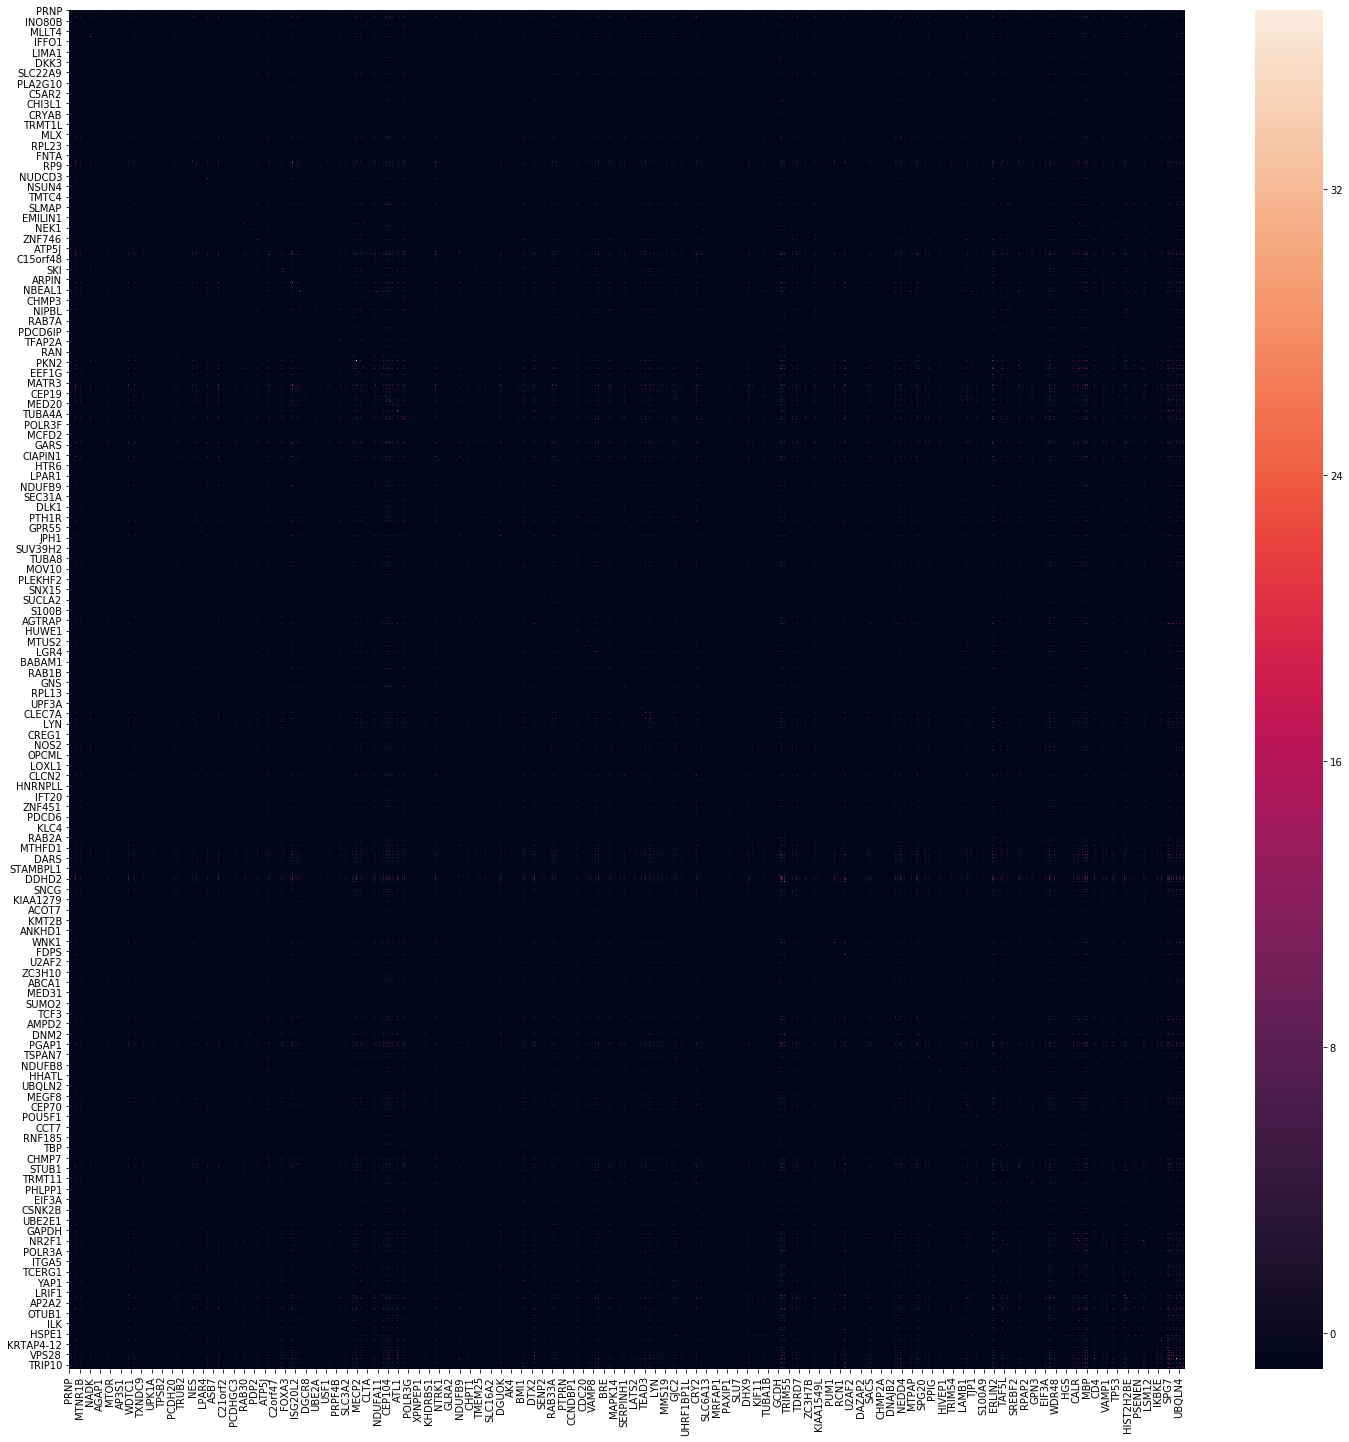

In [14]:
a4_dims = (25, 25)
fig, ax = plt.subplots(figsize=a4_dims)

plt1 = sns.heatmap(float_matrix_sub_1)

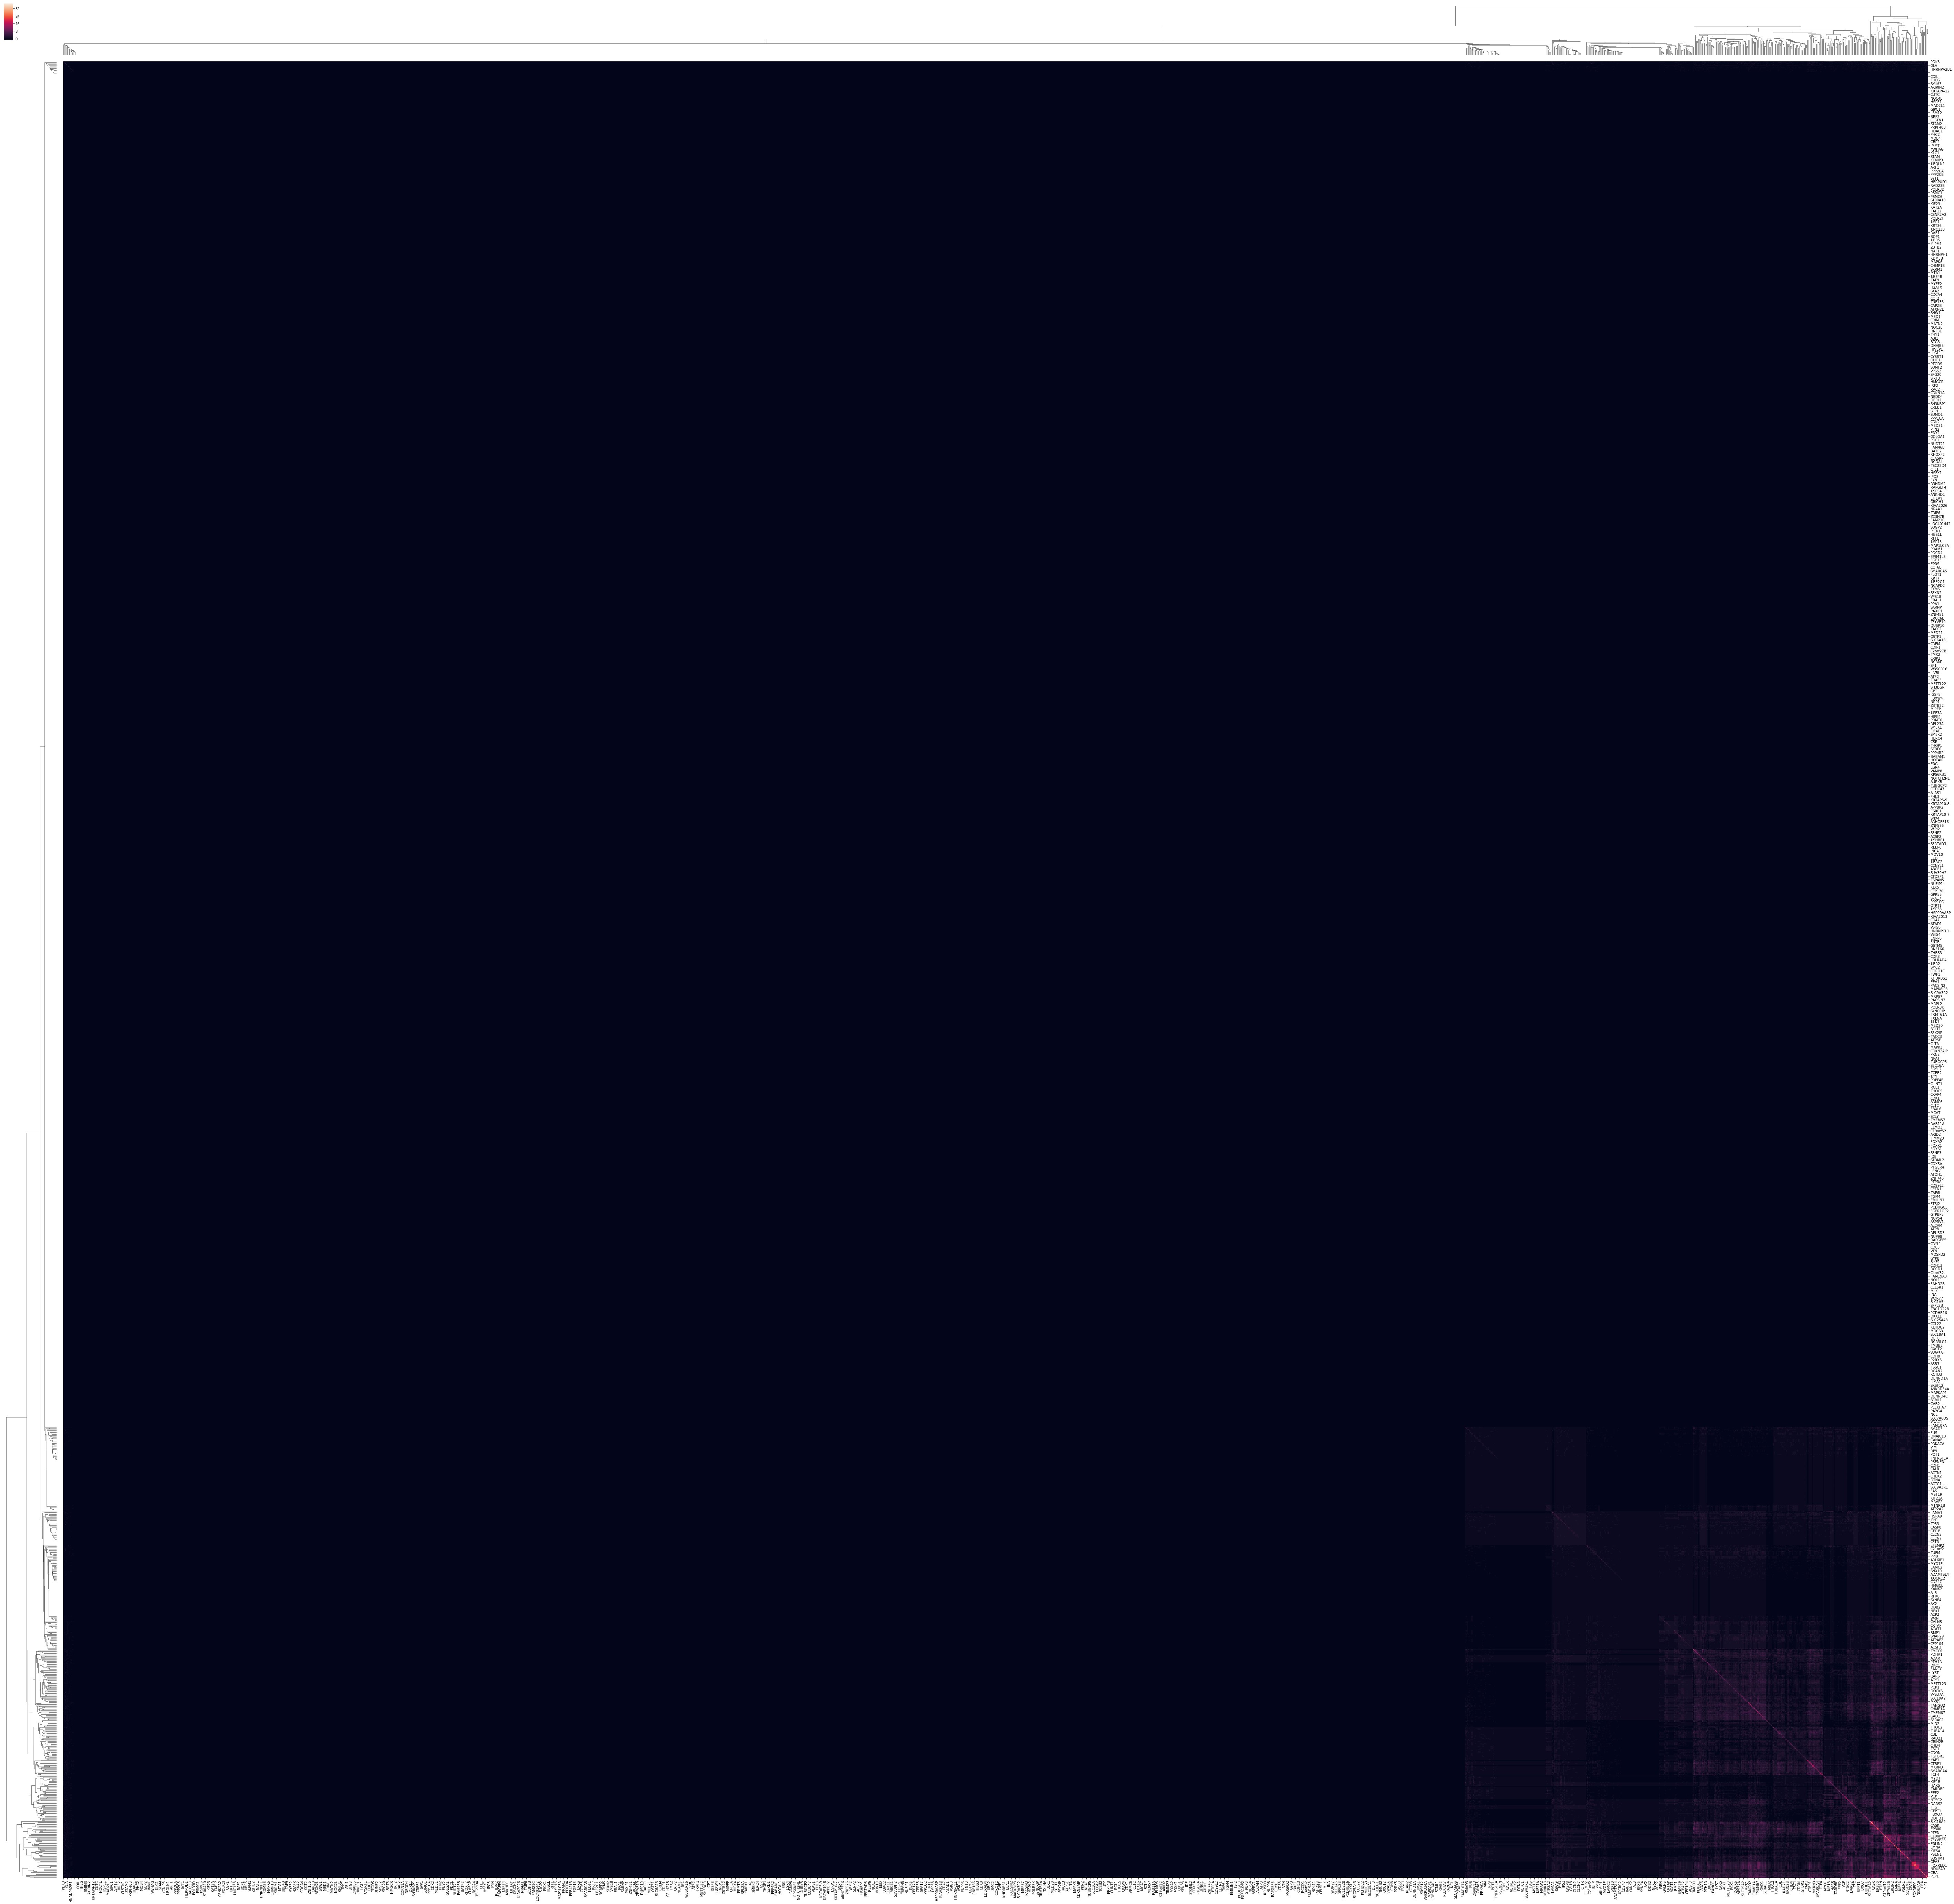

In [38]:
plt2 = sns.clustermap(float_matrix_sub_1, figsize=(100,100))